# Main

This is the main script for this project. Please find the output video at the bottom of this notebook. You can also find it as a mp4 file saved in the *output_images/* folder of this repository. All functions are explained individually as in their corresponding pydocs and all the intermediate steps are described as comments throughout this notebook.

Note that this notebook does not include the step-by-step visualizations of the overall line detection pipeline. For that, please refer to the notebook *examples/pipeline_explained_with_visualizations.ipynb*.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
import os
# %matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9, 6), corners, ret)
        plt.figure()
        plt.imshow(img)

# Compute camera calibration matrices using the calibration images.
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


# A random image to test the calibration result
ln_test_imgs = glob.glob('test_images/*.jpg')
ln_test_imgs


['test_images/test1.jpg',
 'test_images/test3.jpg',
 'test_images/straight_lines2.jpg',
 'test_images/test4.jpg',
 'test_images/straight_lines1.jpg',
 'test_images/test5.jpg',
 'test_images/test6.jpg',
 'test_images/test2.jpg']

In [6]:
def hist(img):
    """
    We can take only the bottom half of the image since lane lines are tend to be vertical at that area.
    """
    # Take the bottom half of the image
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram


def calc_cam_dist(right_fitted_x, left_fitted_x, warped_img, xm_per_pix):
    """
    Calculate the camera distance to the center of lane.
    """
    # Find the center point of the lane that is closest to the car
    ego_lane = (left_fitted_x.max() + right_fitted_x.min()) / 2
    # Calculate the camera distance to the center point from the previous step
    dist_to_center = ego_lane - (warped_img.shape[1] / 2)
    # In meters
    dist_to_center *= xm_per_pix
    return dist_to_center


class LaneLine:
    """
    This class represents the lane lines.
    """
    def __init__(self):

        self.coeffs = None

        # Keep track of the lane angle and the cam distance
        self.radius_of_curvature = 0
        self.cam_dist_to_center  = 0
        # Pre-determined values about the lane lines
        self.lane_length = 30
        self.lane_width  = 3.7

        # Meters per pixel
        self.ym_per_pix = self.lane_length / 720
        self.xm_per_pix = self.lane_width / 1200

    def update_coeffs(self, coeffs):
        """
        Update line coefficients
        """
        self.coeffs = coeffs
    
    def calc_radius(self, in_meters=True):
        """
        Calculate the angle of the lane line.
        """
        if self.coeffs is None:
            print('Line coefficients does not exist yet!')
            return
        # This is to determine points in the y axis
        ploty = np.linspace(0, 719)
        # Calculate angle in meters
        if in_meters:
            self.radius_of_curvature = ((1 + (2 * self.coeffs[0] * np.max(ploty) * self.ym_per_pix + self.coeffs[1]) ** 2) ** 1.5) / np.absolute(2 * self.coeffs[0])
        # Calculate angle in pixel coords
        else:
            self.radius_of_curvature = ((1 + (2 * self.coeffs[0] * np.max(ploty) + self.coeffs[1]) ** 2) ** 1.5) / np.absolute(2 * self.coeffs[0])

        return self.radius_of_curvature
        

class AdvancedLaneDetector:
    """
    Overall pipeline for lane detection
    """
    def __init__(self, mtx, dist):
        # Camera calibration parameters
        self.mtx = mtx
        self.dist = dist
        
        # Number of sliding windows
        self.nwindows = 9
        # Width of the windows +/- margin
        self.margin = 100
        # Minimum number of pixels found to recenter window
        self.minpix = 50

        self.right_line = LaneLine()
        self.left_line = LaneLine()

    def undistort(self, img):
        """
        Undistort the input image using the camera distance and transformation matrices that are calibrated.
        """
        return cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
        
    def detect_lines(self, img):
        """
        Combine gradient and color threshold to detect lines.
        """
        # Undistort the image
        undst_ln_img = self.undistort(img)
        
        # Extract the s channel information using the hls format
        hls = cv2.cvtColor(undst_ln_img, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]
        
        # Convert to gray scale for binary operations
        gray = cv2.cvtColor(undst_ln_img, cv2.COLOR_RGB2GRAY)
        # Take the derivative in x
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) 
        # Compute the absolute x derivative to accentuate lines away from horizontal
        abs_sobelx = np.absolute(sobelx)
        # Emphasize the sobel output in terms of the color
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

        # Threshold x gradient
        thresh_min = 20
        thresh_max = 100
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

        # Threshold color channel
        s_thresh_min = 170
        s_thresh_max = 255
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

        # Combine the two binary thresholds into one image
        combined_binary = np.zeros_like(sxbinary)
        combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

        return combined_binary
    
    def perspective_transform(self, ln_img):
        """
        Transform the input image so that the lane lines are viewed in BEV.
        """
        height = ln_img.shape[0]
        width = ln_img.shape[1]
        # Vertices coordinates in the source image
        s1 = [575, 460]
        s2 = [710, 460]
        s3 = [315, height]
        s4 = [1120, height]
        src = np.float32([s1, s2, s3, s4])
        # Vertices coordinates in the destination image
        d1 = [300, 0]
        d2 = [900, 0]
        d3 = [300, height]
        d4 = [900, height]
        dst = np.float32([d1, d2, d3, d4])
        
        # Given src and dst points we compute the transformation matrix to switch view
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using the matrix
        warped = cv2.warpPerspective(ln_img, M, (width, height))
        # Calculate the oposite transform for returning to the original perspective
        M_inv = cv2.getPerspectiveTransform(dst, src)
        
        return warped, M_inv
    
    def fit_polynomial(self, binary_warped):
        """
        Fit a polynomial to get the coefficients defining the each lane line.
        """
        # Find lane pixels
        leftx, lefty, rightx, righty, out_img = self.find_lane_pixels(binary_warped)

        # Fit a second order polynomial to each line
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Assign the new line coeffs to the LaneLines'
        self.left_line.update_coeffs(left_fit)
        self.right_line.update_coeffs(right_fit)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        # Get the x coordinates using the y values and the line coefficients
        try:
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        except TypeError:
            # Avoid the error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty

        return left_fitx, right_fitx, left_fit, right_fit
    
    def find_lane_pixels(self, binary_warped):
        """
        Find pixels that define the lane lines.
        """
        # Compute the histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint


        # Set height of windows based on number of windows and image shape
        window_height = np.int(binary_warped.shape[0] // self.nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(self.nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - self.margin
            win_xleft_high = leftx_current + self.margin
            win_xright_low = rightx_current - self.margin
            win_xright_high = rightx_current + self.margin

            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low), (win_xleft_high,win_y_high), (0,255,0), 2)
            cv2.rectangle(out_img,(win_xright_low,win_y_low), (win_xright_high,win_y_high), (0,255,0), 2) 

            # Identify the nonzero pixels in x and y within the window #
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If found > minpix pixels -> recenter next window on the mean position
            if len(good_left_inds) > self.minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > self.minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Avoids the error
            pass

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        return leftx, lefty, rightx, righty, out_img

    def draw_lane(self, img, warped_img, Minv, leftfitx, rightfitx):
        """
        Draw the computed lane in semi-transparent green for visualization.
        """
        # Create y coordinates that'll be used for generating x coords of the lines
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped_img).astype(np.uint8)
        # An image should consist of 3 channels
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([leftfitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([rightfitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
        # Combine the result with the original image
        result = cv2.addWeighted(self.undistort(img), 1, newwarp, 0.3, 0)
        # plt.figure()
        # plt.imshow(result)
        # plt.show()

        return result

    def overlay_text(self, frame, text, x, y):
        """
        Put a text on the top-left corner of the image for convenience.
        """
        cv2.putText(frame, text, (x, y), cv2.FONT_HERSHEY_DUPLEX, 0.8, (255, 255, 255), 2)


    def run(self, frame):
        """
        Run the whole pipeline for lane detection from input image to the final visualization.
        """
        # Detect the lines using thresholding
        thresholded = self.detect_lines(frame)
        # Perspective transform to get to the BEV
        persp_transformed, Minv = self.perspective_transform(thresholded)
        # Compute line equations and the corresponding x coordinates
        left_fitx, right_fitx, left_coeffs, right_coeffs = self.fit_polynomial(persp_transformed)  # Updates the line coeffs inside
        # Compute the angle of the lane in meters
        radius_in_meters_right = self.right_line.calc_radius(in_meters=True)
        radius_in_meters_left = self.left_line.calc_radius(in_meters=True)
        radius_in_meters = (radius_in_meters_right + radius_in_meters_left) / 2
        # Compute the distance of the cam to the center of the lane
        dist_to_cent = calc_cam_dist(right_fitx, left_fitx, warped_img=persp_transformed, xm_per_pix=3.7/1200)
        # Visualize the output of the pipeline: the lane
        res = self.draw_lane(frame, persp_transformed, Minv, left_fitx, right_fitx)
        # Put radius of curvature and the distance to the center information on the visualization for convenience
        self.overlay_text(res, 'Radius of curvature:  {:.2f} m'.format(radius_in_meters), 850, 80)
        self.overlay_text(res, 'Distance of center:    {:.1f} m'.format(dist_to_cent), 850, 140)
        return res

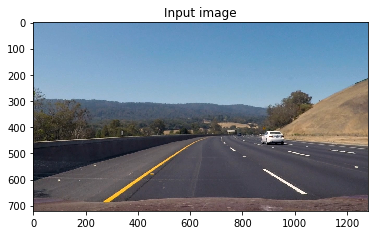

[MoviePy] >>>> Building video output_images/project_video_augmented_2.mp4
[MoviePy] Writing video output_images/project_video_augmented_2.mp4


100%|█████████▉| 1260/1261 [04:27<00:00,  4.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_augmented_2.mp4 



In [7]:
test_img = plt.imread(ln_test_imgs[1])
plt.imshow(test_img)
plt.title('Input image')
plt.show()

lane_detector = AdvancedLaneDetector(mtx=mtx, dist=dist)


def create_output_video(video_path):
    output_video_name = 'output_images/{}_output.mp4'.format(os.path.splitext(video_path)[0])
    input_video = VideoFileClip(video_path)

    lane_detector = AdvancedLaneDetector(mtx=mtx, dist=dist)
    res = lane_detector.run(input_video.get_frame(0))

    # calibrated = calibrated_camera(input_video.get_frame(0))
    # pipeline = Pipeline(calibrated)

    output_video = input_video.fl_image(lane_detector.run)

    output_video.write_videofile(output_video_name, audio=False)


# test_out = lane_detector.run(test_img)

create_output_video(video_path='project_video.mp4')

In [9]:
from IPython.display import Video

In [11]:
Video("output_images/project_video_output.mp4")

# Discussion

In this project, I learned a lot by combining variety of methods in order to find the lane lines from a raw input image. Calibrating the camera as finding the transformation and the distance matrices is an important step, especially while calculating the real world distances. After undistorting the input image, using a combination of color and gradient thresholding with the proper parameters is the key point of detecting the lane lines. Using only one of them is not usually sufficient by means of different lighting and other conditions such as the position of the car. Thus combining both yields more robust results in detecting the lines. Computing the radius of curvature and the distance to the ego lane center are essential parts of autonomous driving to make decisions in the planning part.

However, this overall approach is not the best way to detect the lines, as it will struggle in extreme conditions and on roads with more curves. That's why neural net based algorithms are preferred to such rule-based methods. They can adapt and generalize better in different lighting and position conditions.